## How to use TreeMap

In [670]:
# Import File
from TreeMap.TreeMap import TreeMap

### Constructors
1. Empty Constructor
2. Pass a Key-Value pair
3. Pass a Dictionary

In [671]:
rb = TreeMap()
rb

{}

In [672]:
rb = TreeMap(1, 5)
rb

{1: 5}

In [673]:
d = {1:"One", 2: 2}
rb = TreeMap(d)
rb

{1: One, 2: 2}

### Insertion
1. put(key, value)
2. put_all(dict)

In [674]:
rb.put(3, 'Three')
rb

{1: One, 2: 2, 3: Three}

In [675]:
d = {4:4.2, 5:'Five'}
rb.put_all(d)
rb

{1: One, 2: 2, 3: Three, 4: 4.2, 5: Five}

Since duplicates are not allowed, if we try to insert a duplicate key, the value in it will be updated

In [676]:
rb.put(5,5)
rb

{1: One, 2: 2, 3: Three, 4: 4.2, 5: 5}

### Retreival
1. get(key) -> Returns the value with that key if found otherwiser returns None
2. get_keys() -> Returns a list of keys
2. get_values() -> Returns a list of values

In [677]:
rb.get(1)

'One'

In [678]:
rb.get_keys()

[1, 2, 3, 4, 5]

In [679]:
rb.get_values()

['One', 2, 'Three', 4.2, 5]

### Deletion 
1. remove(key) -> If key is present, will delete it, else will raise key error, returns None
2. clear()

In [680]:
rb.remove(1)
rb

{2: 2, 3: Three, 4: 4.2, 5: 5}

In [681]:
rb.clear()
rb

{}

In [682]:
d = {1:"One", 2: 2, 3:3, 4:4.2, 5:'Five'}
rb = TreeMap(d)
rb

{1: One, 2: 2, 3: 3, 4: 4.2, 5: Five}

### Supplementary Methods

1. size() -> Returns the number of elements
2. contains_key(key) -> Returns True if the key is present else returns False
3. contains_value(value) -> Returns True if the value is present else returns False 
4. first_key() -> Returns the first key
5. first_entry() -> Returns the first key-value pair as a dictionary
6. poll_first_entry() -> Returns the first key-value pair as a dictionary and deletes it
7. last_key() -> Returns the last key
8. last_entry() -> Returns the last key-value pair as a dictionary
9. poll_last_entry() -> Returns the last key-value pair as a dictionary and deletes it
10. visaulize_tree() -> Displays a plot with the structure of the internal red-black tree


In [683]:
rb.size()

5

In [684]:
print(rb.contains_key(9))
print(rb.contains_key(1))

False
True


In [685]:
print(rb.contains_value('Five'))
print(rb.contains_value(10))

True
False


In [686]:
rb.first_key()

1

In [687]:
rb.first_entry()

{1: 'One'}

In [688]:
rb.poll_first_entry()
rb

{2: 2, 3: 3, 4: 4.2, 5: Five}

In [689]:
rb.last_key()

5

In [690]:
rb.last_entry()

{5: 'Five'}

In [691]:
rb.poll_last_entry()
rb

{2: 2, 3: 3, 4: 4.2}

In [692]:
# Inserting values to help visualizing the tree
for i in range(5, 10):
    rb.put(i, i)
for i in range(15, 10, -1):
    rb.put(i,i)

In [693]:
rb

{2: 2, 3: 3, 4: 4.2, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}

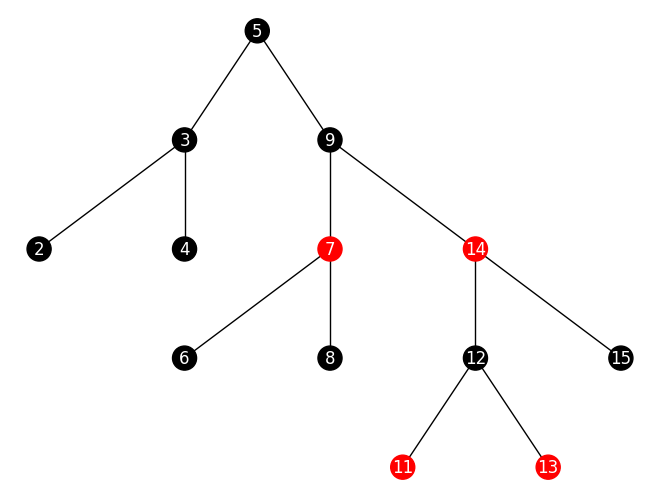

In [694]:
rb.visaulize_tree()